In [1]:
import os
import time
import math
import random
from datetime import datetime
from collections import namedtuple

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import gym
from gym.envs.registration import register

In [2]:
# disable TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.optimizers import RMSprop

In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity=1_000_000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size=32):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
memory = ReplayMemory()
len(memory)

0

In [5]:
env_name = 'CartPole-v0'
env = gym.make(env_name)

## Hyperparameters

In [12]:
input_shape = env.observation_space.shape
n_actions = env.action_space.n
lr = 0.0001
BATCH_SIZE = 32
GAMMA = 0.99
update_freq = 10_000

EPS_START = 1 # initial value of epsilon
EPS_END = 0.1 # final value of epsilon
EPS_DECAY = 20_000 # number of steps until epsilon reach its final value
steps_done = 0

In [7]:
def create_network(name, input_shape, n_actions, lr):
    model = keras.Sequential(name=name, layers=[
        Dense(
            name=f'{name}_dense_01',
            units=32,
            input_shape=input_shape,
            # activation='sigmoid',
        ),
        Dense(
            name=f'{name}_dense_02',
            units=32,
            # activation='sigmoid',
        ),
        Dense(
            name=f'{name}_dense_03',
            units=n_actions,
            activation='linear',
        )
    ])

    optimizer = RMSprop(lr=lr)

    model.compile(
        optimizer=optimizer,
        loss='mse',
    )

    return model

In [8]:
target_net = create_network(
    name='target_net',
    input_shape=input_shape,
    n_actions=n_actions,
    lr=lr
)

target_net.summary()

policy_net = create_network(
    name='policy_net',
    input_shape=input_shape,
    n_actions=n_actions,
    lr=lr
)

policy_net.summary()

Model: "target_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
target_net_dense_01 (Dense)  (None, 32)                160       
_________________________________________________________________
target_net_dense_02 (Dense)  (None, 32)                1056      
_________________________________________________________________
target_net_dense_03 (Dense)  (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
Model: "policy_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
policy_net_dense_01 (Dense)  (None, 32)                160       
_________________________________________________________________
policy_net_dense_02 (Dense)  (None, 32)                1056      
__________________________________

In [9]:
def target_to_policy():
    for i in range(len(policy_net.weights)):
        tf.keras.backend.set_value(policy_net.weights[i], target_net.weights[i].numpy())

def policy_to_target():
    for i in range(len(target_net.weights)):
        tf.keras.backend.set_value(target_net.weights[i], policy_net.weights[i].numpy())

Copy weights from target network to policy network

In [10]:
target_to_policy()

In [13]:
def select_action(state):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    if sample > eps_threshold:
        batch = np.array([state])
        action = np.argmax(policy_net.predict(batch)[0])
    else:
        action = random.randrange(n_actions)

    return action

In [14]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    # transpose the batch
    batch = Transition(*zip(*transitions))
    
    s = np.array(batch.state)
    a = np.array(batch.action)
    r = np.array(batch.reward)
    
    non_final_mask = np.array(list(map(lambda s: s is not None, batch.next_state)))
    non_final_s2 = np.array([s for s in batch.next_state if s is not None])
    
    # compute V(s_{t+1}) for all next states (except for terminal states)
    s2_values = target_net.predict(non_final_s2)
    target_q = np.zeros((BATCH_SIZE, n_actions), dtype=np.float32)
    s2_index = 0
    for i in range(BATCH_SIZE):
        if non_final_mask[i]:
            target_q[i][a[i]] = np.max(s2_values[s2_index]) * GAMMA + r[i]
            s2_index += 1
    
    policy_net.fit(
        x=s,
        y=target_q,
        verbose=0,
    )

## Training loop

In [15]:
state = env.reset()
reward = 0

for step_num in tqdm(range(100_000)):
    action = random.randrange(n_actions)
    next_state, reward, done, info = env.step(action)
    
    if done:
        next_state = None
    memory.push(state, action, next_state, reward)
    
    if done:
        state = env.reset()
    else:
        state = next_state
    
    optimize_model()
    
    if step_num % update_freq == 0:
        policy_to_target()

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [10:44<00:00, 155.04it/s]


## Populate memory for testing

In [ ]:
state = env.reset()
reward = 0

for _ in tqdm(range(100_000)):
    action = random.randrange(n_actions)
    next_state, reward, done, info = env.step(action)
    
    if done:
        next_state = None
    memory.push(state, action, next_state, reward)
    
    if done:
        state = env.reset()
    else:
        state = next_state

## Evaluate target network

Use random as baseline

Total reward: 34.0


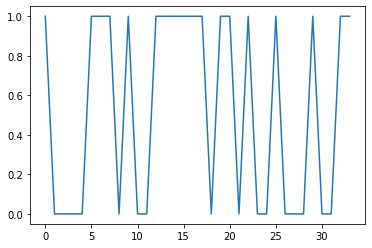

In [26]:
state = env.reset()

total_reward = 0
max_steps = 2_000
action_log = []

for _ in range(max_steps):
    action = random.randrange(env.action_space.n)
    action_log.append(action)
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    
    state = next_state

    if done:
        break

print('Total reward:', total_reward)
action_log = np.array(action_log)
plt.plot(action_log)

Total reward: 9.0


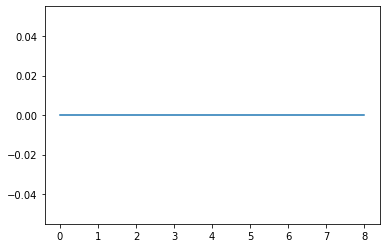

In [25]:
state = env.reset()

total_reward = 0
max_steps = 2_000
action_log = []

for _ in range(max_steps):
    action = np.argmax(target_net.predict(np.array([state]))[0])
    action_log.append(action)
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    
    state = next_state

    if done:
        break

print('Total reward:', total_reward)
action_log = np.array(action_log)
plt.plot(action_log)

## Evaluate visually

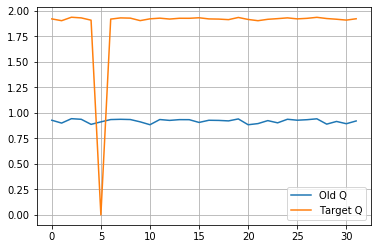

In [36]:
transitions = memory.sample(BATCH_SIZE)
# transpose the batch
batch = Transition(*zip(*transitions))

s = np.array(batch.state)
a = np.array(batch.action)
r = np.array(batch.reward)

non_final_mask = np.array(list(map(lambda s: s is not None, batch.next_state)))
non_final_s2 = np.array([s for s in batch.next_state if s is not None])

# compute V(s_{t+1}) for all next states (except for terminal states)
s2_values = target_net.predict(non_final_s2)
target_q = np.zeros((BATCH_SIZE, n_actions), dtype=np.float32)

# DEBUG
s_q = target_net.predict(s)
_old_q = []
_target_q = []
# END_DEBUG

s2_index = 0
for i in range(BATCH_SIZE):
    if non_final_mask[i]:
        target_q[i][a[i]] = np.max(s2_values[s2_index]) * GAMMA + r[i]
        # DEBUG
        _old_q.append(s_q[i][a[i]])
        _target_q.append(target_q[i][a[i]])
        # END_DEBUG
        s2_index += 1
    else:
        # DEBUG
        _old_q.append(s_q[i][a[i]])
        _target_q.append(0)
        # END_DEBUG
_old_q = np.array(_old_q)
_target_q = np.array(_target_q)

plt.plot(_old_q, label='Old Q')
plt.plot(_target_q, label='Target Q')
plt.legend()
plt.grid()